In [1]:
%matplotlib inline
import os
import glob
from collections import defaultdict

import torch
import torch.nn as nn
import torchvision
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import trange, tqdm
from torchvision import transforms
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorflow.python.framework import tensor_util


from source.models import gn_gan, sn_gan_1
from source.models.sn_gan_1 import SpectralNorm, normalize
from source.models.gn_gan import GradNorm


def ema(data, r=0.7):
    ret = []
    for x in data:
        if len(ret) == 0:
            ret.append(x)
        else:
            ret.append(ret[-1] * r + x * (1 - r))
    return np.array(ret)

In [2]:
root = 'cvpr21/rebuttal'
path = [
    ("SN-3L", "SN-GAN-1_CIFAR10_CNN3_WAS"),
    ("GN-3L", "GN-GAN_CIFAR10_CNN3_WAS"),
    ("SN-6L", "SN-GAN-1_CIFAR10_CNN6_WAS"),
    ("GN-6L", "GN-GAN_CIFAR10_CNN6_WAS"),
    ("SN-9L", "SN-GAN-1_CIFAR10_CNN9_WAS"),
    ("GN-9L", "GN-GAN_CIFAR10_CNN9_WAS"),
]

def summary_iterator(dir_path):
    for path in glob.glob(os.path.join(dir_path, '*')):
        if 'events.out.tfevents' in path:
            break
    else:
        raise ValueError("%s is not a log directory" % dir_path)
    try:
        for r in tf.data.TFRecordDataset(path):
            yield event_pb2.Event.FromString(r.numpy())
    except tf.errors.DataLossError:
        return

values = dict()
eval_values = dict()
with tqdm(path) as pbar:
    for legend_name, dir_name in pbar:
        pbar.set_description(legend_name)
        dir_path = os.path.join(root, dir_name)
        x_gn = []
        y_gn = []
        x_eval = []
        y_eval = []
        for event in summary_iterator(dir_path):
            for value in event.summary.value:
                if value.tag == 'rand_gn':
                    x_gn.append(event.step)
                    y_gn.append(value.simple_value)
                if value.tag == "IS":
                    x_eval.append(event.step)
                    y_eval.append(value.simple_value)
        values[legend_name] = (x_gn, y_gn)
        eval_values[legend_name] = (x_eval, y_eval)

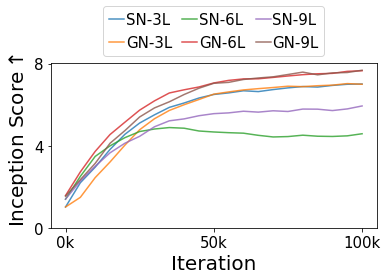

In [3]:
ticks_fontsize = 15
label_fontsize = 20
legend_fontsize = 15

plt.figure(figsize=(5.5, 4))
for legend_name, (x, y) in eval_values.items():
    plt.plot(x, ema(y), label=legend_name, linewidth=1.5, alpha=0.8)

xticks = [0, 50000, 100000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Iteration', fontsize=label_fontsize)
# ax.tick_params(axis='x', labelsize=label_fontsize)

yticks = [0, 4, 8]
plt.yticks(yticks, fontsize=ticks_fontsize)
plt.ylabel('Inception Score' + r'$\uparrow$', fontsize=label_fontsize, y=0.54)

plt.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.7, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(0.5, 1))
plt.tight_layout()
plt.savefig('./figures/vis_IS_vs_CNN.png')

In [4]:
from collections import defaultdict

import torch
import torch.nn as nn
from tqdm.notebook import trange, tqdm

from source.models import gn_gan, sn_gan_1
from source.models.sn_gan_1 import SpectralNorm, normalize

device = torch.device('cuda:1')

def auto_spectral_norm(module, in_dim, iteration=100):
    v = normalize(torch.randn(size=in_dim)).to(device)
    with torch.no_grad():
        output_shape = module(v).shape
    v_dummy = torch.randn(size=in_dim, requires_grad=True).to(device)

    if isinstance(module, SpectralNorm):
        bias = getattr(module.module, 'bias')
    else:
        bias = getattr(module, 'bias')
    while len(bias.shape) < len(output_shape) - 1:
        bias = bias.unsqueeze(-1)

    for _ in trange(iteration, leave=False):
        with torch.no_grad():
            if bias is not None:
                u = normalize(module(v) - bias)
            else:
                u = normalize(module(v))
        v = torch.autograd.grad(module(v_dummy), v_dummy, u)[0]
        with torch.no_grad():
            v = normalize(v)

    with torch.no_grad():
        if bias is not None:
            return torch.dot(u.reshape(-1), (module(v) - bias).reshape(-1))
        else:
            return torch.dot(u.reshape(-1), module(v).reshape(-1))


class ForwardHook:
    def __init__(self):
        self.in_shapes = []
    
    def __call__(self, module, inputs, outputs):
        self.in_shapes.append(list(inputs[0].shape))


root = 'cvpr21/rebuttal'
path = [
#     ("SN-CNN-3layer", "SN-GAN-1_CIFAR10_CNN3_WAS"),
#     ("SN-CNN-6layer", "SN-GAN-1_CIFAR10_CNN6_WAS"),
    ("SN-9L", "SN-GAN-1_CIFAR10_CNN9_WAS", sn_gan_1.Discriminator9().to(device)),
#     ("GN-CNN-3layer", "GN-GAN_CIFAR10_CNN3_WAS"),
#     ("GN-CNN-6layer", "GN-GAN_CIFAR10_CNN6_WAS"),
    ("GN-9L", "GN-GAN_CIFAR10_CNN9_WAS", gn_gan.GradNorm(gn_gan.Discriminator9()).to(device)),
]
spectralnorms = defaultdict(list)

with tqdm(path) as pbar:
    for legend_name, dir_name, net_D in pbar:
        pbar.set_description(legend_name)
        net_D.eval()
        handles = []
        modules = []
        hook = ForwardHook()
        for m in net_D.modules():
            if legend_name.startswith('SN'):
                if isinstance(m, SpectralNorm) and isinstance(m.module, nn.Conv2d):
                    record = True
                else:
                    record = False
            else:
                record = isinstance(m, nn.Conv2d)
            if record:
                handles.append(m.register_forward_hook(hook))
                modules.append(m)
        net_D(torch.rand((1, 3, 32, 32)).to(device)) # initialize shape of u and v
        for handle in handles:
            handle.remove()

        ckpt = torch.load(os.path.join(root, dir_name, 'model.pt'))
        net_D.load_state_dict(ckpt['net_D'])

        for m, in_shape in tqdm(list(zip(modules, hook.in_shapes)), leave=False):
#             print(m)
#             print(in_shape)
            spectralnorms[legend_name].append(auto_spectral_norm(m, in_shape).item())
print(spectralnorms)


defaultdict(<class 'list'>, {'SN-9L': [0.9973885416984558, 0.9972174167633057, 0.9993718266487122, 1.0, 1.0, 0.9999999403953552, 1.0, 1.000000238418579, 0.9999999403953552], 'GN-9L': [2.8315649032592773, 14.014120101928711, 11.16029167175293, 13.560648918151855, 18.42572593688965, 22.061595916748047, 56.99998092651367, 45.34938049316406, 68.5340805053711]})


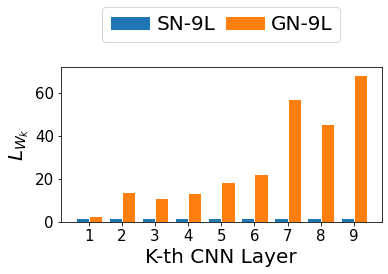

In [5]:
legend_fontsize = 20
ticks_fontsize = 15
label_fontsize = 20
barWidth = 0.4
os.makedirs('./figures', exist_ok=True)

plt.figure(figsize=(5.5, 4))
for i, (legend_name, spectralnorm) in enumerate(spectralnorms.items()):
    if legend_name.startswith('SN'):
        enhence = 2
    else:
        enhence = 1
    r = np.arange(len(spectralnorm)) + i * barWidth
    plt.bar(r, np.array(spectralnorm) * enhence, width=barWidth, edgecolor='white', label=legend_name)
tick_center = np.arange(len(spectralnorm)) + (len(spectralnorms) - 1) * 0.5 * barWidth
xtick_labels = np.arange(len(spectralnorm)) + 1
plt.xticks(tick_center, xtick_labels, fontsize=ticks_fontsize)
plt.xlabel('K-th CNN Layer', fontsize=label_fontsize)

yticks = np.arange(0, 70, 20)
plt.yticks(yticks, yticks, fontsize=ticks_fontsize)
plt.ylabel(r'$L_{W_k}$', fontsize=label_fontsize)

plt.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.5, handlelength=2.0, handletextpad=0.3,
    bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.savefig('./figures/vis_lipschitz_vs_layer.png')

In [6]:
device = torch.device('cuda:1')

def calc_grad_norm(net_D, x):
    x.requires_grad_(True)
    y = net_D(x).mean()
    grad = torch.autograd.grad(y, x)[0]
    gn = torch.sqrt((torch.flatten(grad, start_dim=1) ** 2).sum(dim=1))
    gn = gn * x.shape[0]
    return gn

def estimate_max_grad(net_D, net_G, loader, n=50000, batch_size=64, z_dim=128):
    net_G.eval()
    net_D.eval()
    for p in net_D.parameters():
        p.requires_grad_(False)

#     max_fake_gn = 0
#     for _ in trange(0, n, batch_size, desc="fake", leave=False):
#         with torch.no_grad():
#             z = torch.randn((batch_size, z_dim)).to(device)
#             x = net_G(z)
#         max_fake_gn = max(
#             max_fake_gn,
#             calc_grad_norm(net_D, x).max().cpu().item())
    
    max_fake_gn = 0
    max_real_gn = 0
    max_midd_gn = 0
    for real, _ in tqdm(loader, desc="sampling", leave=False):
        with torch.no_grad():
            z = torch.randn((real.size(0), z_dim)).to(device)
            fake = net_G(z)
        max_fake_gn = max(
            max_fake_gn,
            calc_grad_norm(net_D, fake).max().cpu().item())

        real = real.to(device)
        max_real_gn = max(
            max_real_gn,
            calc_grad_norm(net_D, real).max().cpu().item())
        
        with torch.no_grad():
            t = torch.rand((real.size(0), 1, 1, 1)).to(device)
            midd = fake * t + real * (1 - t)
        max_midd_gn = max(
            max_midd_gn,
            calc_grad_norm(net_D, midd).max().cpu().item())
    
    return {
        'fake': max_fake_gn,
        'real': max_real_gn,
        'midd': max_midd_gn,
    }


z_dim = 128
batch_size = 64
root = 'cvpr21/rebuttal/'
path = [
    ("SN-3L", "SN-GAN-1_CIFAR10_CNN3_WAS_savemore", sn_gan_1.Discriminator3(), sn_gan_1.Generator(z_dim)),
    ("GN-3L", "GN-GAN_CIFAR10_CNN3_WAS_savemore", GradNorm(gn_gan.Discriminator3()), gn_gan.Generator(z_dim)),
    ("SN-6L", "SN-GAN-1_CIFAR10_CNN6_WAS_savemore", sn_gan_1.Discriminator6(), sn_gan_1.Generator(z_dim)),
    ("GN-6L", "GN-GAN_CIFAR10_CNN6_WAS_savemore", GradNorm(gn_gan.Discriminator6()), gn_gan.Generator(z_dim)),
    ("SN-9L", "SN-GAN-1_CIFAR10_CNN9_WAS_savemore", sn_gan_1.Discriminator9(), sn_gan_1.Generator(z_dim)),
    ("GN-9L", "GN-GAN_CIFAR10_CNN9_WAS_savemore", GradNorm(gn_gan.Discriminator9()), gn_gan.Generator(z_dim)),
]

dataset = torchvision.datasets.CIFAR10(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, drop_last=True)

with tqdm(path) as pbar:
    for legend_name, dir_name, net_D, net_G in pbar:
        gn_values = {}
        net_D = net_D.to(device)
        net_G = net_G.to(device)
        net_D(torch.rand((1, 3, 32, 32)).to(device))
        for step in tqdm([1] + list(range(5000, 100001, 5000))):
            ckpt = torch.load(os.path.join(root, dir_name, '%d.pt' % step))
            net_G.load_state_dict(ckpt['net_G'])
            net_D.load_state_dict(ckpt['net_D'])
            gn_dict = estimate_max_grad(net_D, net_G, dataloader, len(dataset), batch_size=batch_size, z_dim=z_dim)
            for gn_name, gn_value in gn_dict.items():
                if gn_name in gn_values:
                    gn_values[gn_name].append(gn_value)
                else:
                    gn_values[gn_name] = [gn_value]
        torch.save({legend_name: gn_values}, '%s.pt' % legend_name)

Files already downloaded and verified


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???



???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???



???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???



???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???



???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???



???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???


???
???
???




In [2]:
values = dict()
values.update(torch.load('SN-3L.pt'))
values.update(torch.load('GN-3L.pt'))
values.update(torch.load('SN-6L.pt'))
values.update(torch.load('GN-6L.pt'))
values.update(torch.load('SN-9L.pt'))
values.update(torch.load('GN-9L.pt'))

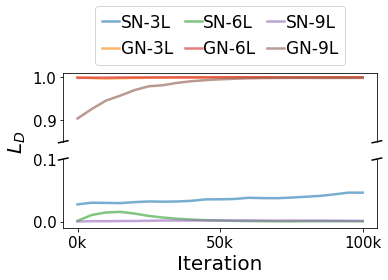

In [5]:
legend_fontsize = 20
ticks_fontsize = 15
label_fontsize = 20

more_values = defaultdict(list)
order = ['SN-3L', 'GN-3L', 'SN-6L', 'GN-6L', 'SN-9L', 'GN-9L']
for legend_name in order:
    gns = values[legend_name]
    x = [1] + list(range(5000, 100001, 5000))
    y = []
    for fake_gn, real_gn, midd_gn in zip(gns['fake'], gns['real'], gns['midd']):
        max_gn = max([fake_gn, real_gn])
        y.append(max_gn)
    more_values[legend_name] = (x, y)

legend_fontsize = 17

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5.5, 4))
fig.subplots_adjust(hspace=5)
ax1.set_ylim(0.85, 1.01)
ax2.set_ylim(-0.01, 0.1)

# setup ticks
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=True)

# turn off spines
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d = 0.015  # line length 
ax1.plot((-d, +d), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax1.plot((1 - d, 1 + d), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax2.plot((-d, +d), (1 - d, (1 + d)), c='k', clip_on=False, transform=ax2.transAxes)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), c='k', clip_on=False, transform=ax2.transAxes)

for legend_name, (x, y) in more_values.items():
    ax1.plot(x, ema(y), label=legend_name, linewidth=2.5, alpha=0.6)
    ax2.plot(x, ema(y), label=legend_name, linewidth=2.5, alpha=0.6)

# lower figure
xticks = [0, 50000, 100000]
yticks = [0, 0.1]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks_label)
ax2.tick_params(axis='x', labelsize=ticks_fontsize)
ax2.set_xlabel('Iteration', fontsize=label_fontsize)
ax2.set_yticks(yticks)
ax2.tick_params(axis='y', labelsize=ticks_fontsize)

# lower upper
yticks = [0.9, 1.0]
ax1.set_yticks(yticks)
ax1.tick_params(axis='y', labelsize=ticks_fontsize)
ax1.set_ylabel(r'$L_D$', fontsize=label_fontsize, y=0)

ax1.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.7, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.savefig('./figures/vis_lipschitz_vs_depth.png')